## _*A Variational Quantum Classifier*_

The QSVM notebook demonstrates a kernel based approach. This notebook shows a variational method.

For further information please see: [https://arxiv.org/pdf/1804.11326.pdf](https://arxiv.org/pdf/1804.11326.pdf)


**This notebook shows the variational quantum classifier method.**

In this file, we show two ways for using the variational quantum classifier: (1) the declarative approach and (2) the programmatic approach. 


### Part I: declarative approach.
In the declarative approach, we config a json-like configuration, which defines how the vqc instance is internally constructed. After the execution, it returns the json-like output, which carries the important information (e.g., the details of the vqc instance) and the processed results. 

In [ ]:
from datasets import *
from qiskit import BasicAer
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput

import ipywidgets as widgets
from IPython.display import display

In [ ]:
optimizer_wdgt = widgets.Dropdown(
    options=['ADAM', 'CG', 'COBYLA', 'L_BFGS_B', 'NELDER_MEAD', 'P_BFGS', 'POWELL', 'SLSQP', 'SPSA', 'TNC', 'AQGD'],
    value='SPSA',
    description='Optimizer:',
    disabled=False,
)

In [ ]:
max_trials_wdgt = widgets.IntSlider(
    value=2,
    min=1,
    max=200,
    step=1,
    description='Max trials:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [ ]:
feature_map_wdgt = widgets.Dropdown(
    options=['FirstOrderExpansion', 'SecondOrderExpansion'],
    value='SecondOrderExpansion',
    description='Feature map:',
    disabled=False,
)

In [ ]:
feature_map_depth_wdgt = widgets.IntSlider(
    value=2,
    min=1,
    max=5,
    step=1,
    description='Depth:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [ ]:
display(optimizer_wdgt)
display(max_trials_wdgt)
display(feature_map_wdgt)
display(feature_map_depth_wdgt)

First we prepare the dataset, which is used for training, testing and the finally prediction.

*Note: You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.*

<IPython.core.display.Javascript object>


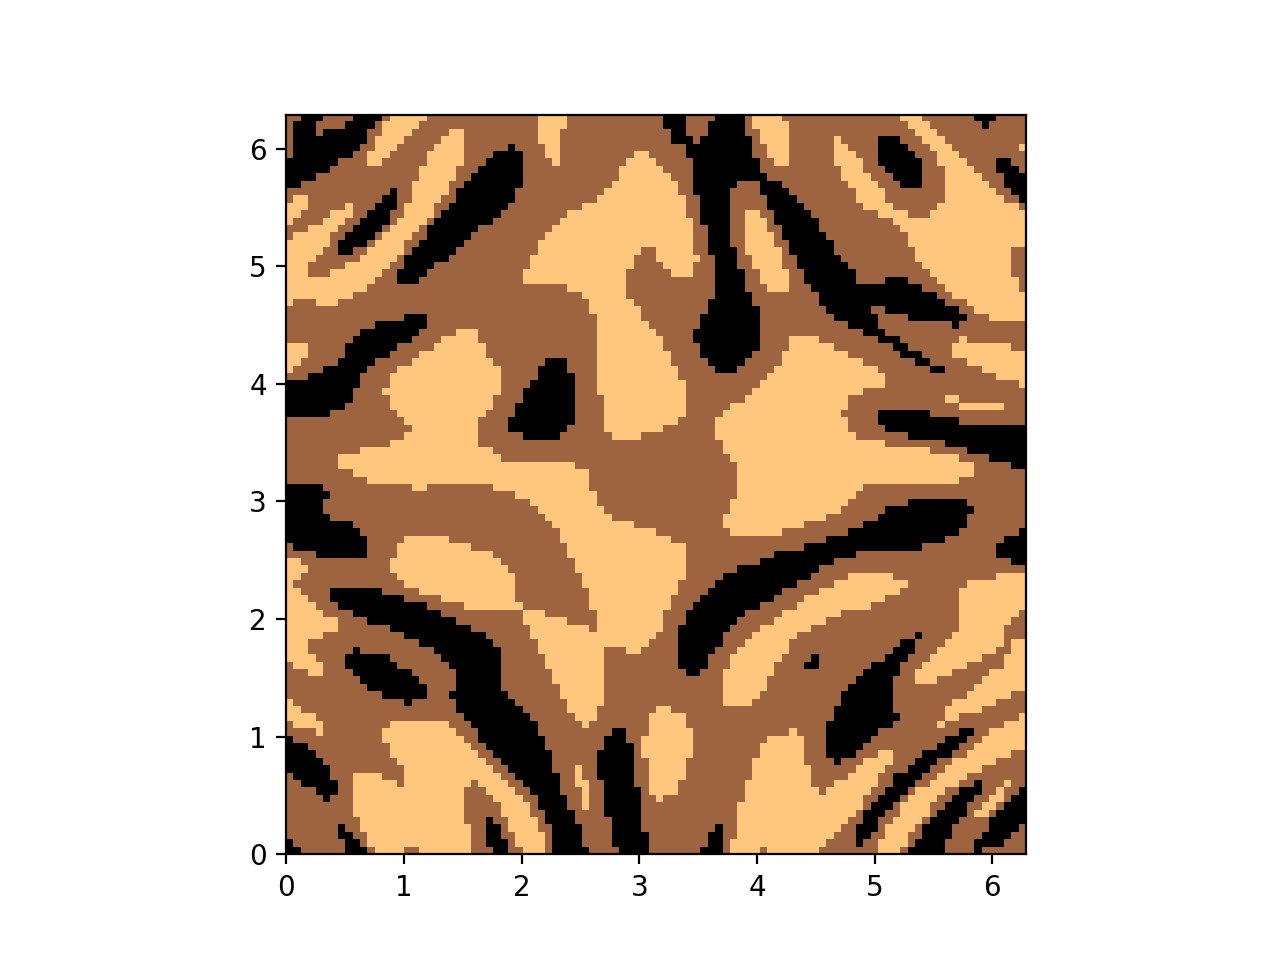

<IPython.core.display.Javascript object>


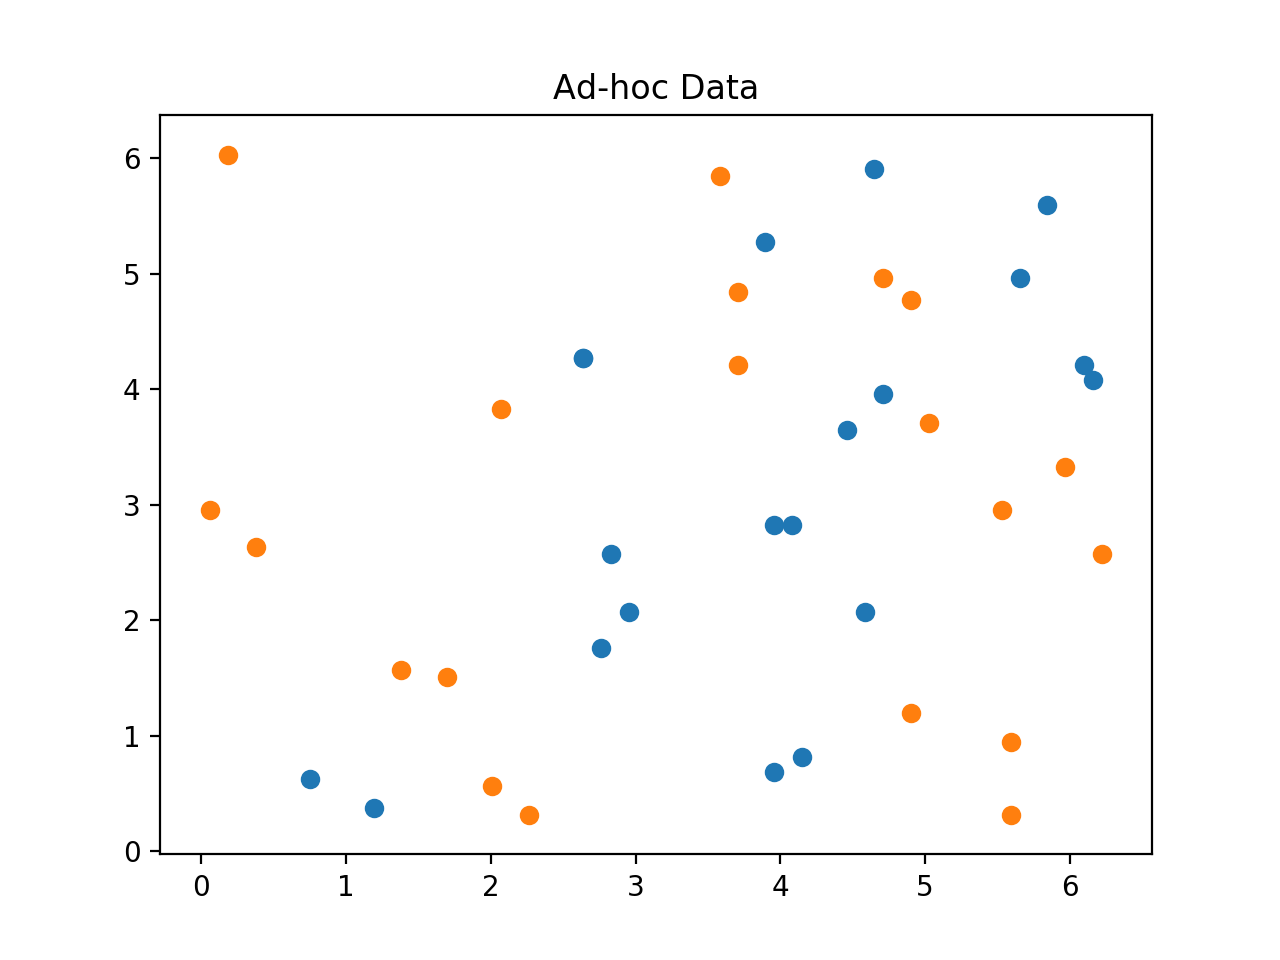

{'A': 0, 'B': 1}


In [48]:
feature_dim = 4 # dimension of each data point
training_dataset_size = 100
testing_dataset_size = 50
random_seed = 10598
shots = 10

sample_Total, training_input, test_input, class_labels = Iris(
    training_size=training_dataset_size, 
    test_size=testing_dataset_size, 
    n=feature_dim, PLOT_DATA=True
)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)

### Part II: programmatic approach.
We construct the vqc instance directly from the classes. The programmatic approach offers the users better accessibility, e.g., the users can access the internal state of vqc instance or invoke the methods of the instance. 

Now we create the vqc in the programmatic approach.
- we build the optimizer instance (required by the vqc instance) by instantiating the class SPSA.
- We build the feature map instance (required by the vqc instance) by instantiating the class SecondOrderExpansion.
- We build the varitional form instance (required by the vqc instance) by instantiating the class RYRZ.
- We build the vqc instance by instantiating the class VQC. 


In [49]:
import matplotlib.pyplot as plt
costs = []
# plt.plot(costs)
# plt.ylabel('some numbers')
# plt.show()

In [55]:
def cost_update_callback(eval_count, parameters, cost, batch_index):
    print(eval_count, cost)
    costs.append(cost)
    plt.ylabel('Cost')
    plt.plot(np.arange(len(costs)), costs)
    # plt.show()

In [56]:
backend = BasicAer.get_backend('qasm_simulator')
optimizer = SPSA(max_trials=max_trials_wdgt.value, c0=4.0, skip_calibration=True)
optimizer.set_options(save_steps=1)
feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=feature_map_depth_wdgt.value)
var_form = RYRZ(num_qubits=feature_dim, depth=3)
vqc = VQC(optimizer, feature_map, var_form, training_input, test_input, callback=cost_update_callback)
quantum_instance = QuantumInstance(backend, shots=shots, seed=random_seed, seed_transpiler=random_seed)

Now we run it.

In [57]:
result = vqc.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

0 0.9718834898768286
1 0.8291085859688886
2 0.7827434008725302
3 0.8637752209551541
4 0.8947067523132415
5 1.1190123064986959
6 0.8794138544088849
7 0.8245808916813381
8 1.0102888079117405
9 0.8276552975994151
10 0.45497090087625125
11 0.44826577927144867
12 0.4978723631221095
13 0.42790234103094243
14 0.9292408315029824
15 0.7443746851403579
16 0.8272778670727139
17 0.8612927958740693
18 0.8277015257538778
19 1.0950003908286294
20 0.6125718428934068
21 0.606190509505935
22 0.6088052602861413
23 0.6180265453775237
24 0.588374572215957
25 0.6301099772591742
26 0.44120397274377476
27 0.6576887891974443
28 0.4629860177990749
29 0.41437009210152914
30 0.45299786766990396
31 0.5078147962210966
32 0.46427819222338973
33 0.523799787179491
34 0.4406506403547111
35 0.4101180867032269
36 0.45485018624462337
37 0.3880369023387193
38 0.5401302121675287
39 0.5479239025394107
40 0.5386076575142331
testing success ratio:  0.8


Different from the declarative approach, the programmatic approach allows the users to invoke APIs upon the vqc instance directly. In the following, we invoke the API "predict" upon the trained vqc instance to predict the labels for the newly provided data input.

Use the trained model to evaluate data directly, and we store a label_to_class and class_to_label for helping converting between label and class name

In [79]:
predicted_probs, predicted_labels = vqc.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, vqc.label_to_class)
print("prediction:   {}".format(predicted_labels))

prediction:   [0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 1]
